# Automated Correlation-Based Stock Classification with Machine Learning Forecasting

### Project Summary

A comprehensive Python-based system that automatically classifies stocks into correlation-based groups and applies machine learning models for price forecasting. The project incorporated extensive research and testing of multiple correlation methodologies including Pearson, Spearman, EWMA, Rolling Window, Kendall Tau, Partial Correlation, Distance Correlation, Mutual Information, and Copula-Based correlation to determine the optimal approach for financial time series analysis.

Through systematic evaluation, EWMA (Exponentially Weighted Moving Average) correlation was selected as the primary methodology due to its superior ability to weight recent market data more heavily while maintaining computational efficiency in volatile market conditions.

The platform processes 200+ stock tickers with complete daily historical data using the yfinance API, with scalable architecture designed to handle significantly larger datasets. The correlation engine dynamically groups stocks based on configurable minimum correlation thresholds, enabling flexible analysis across different market conditions and sectors.

Following comprehensive research and comparative testing of machine learning approaches including Neural Networks, Long Short-Term Memory (LSTM) networks, Recurrent Neural Networks (RNN), Random Forest, Support Vector Machines (SVM), Gradient Boosting methods, and Time Series Transformers, the system implements the optimal forecasting model selected based on performance metrics.

Through systematic evaluation, _______ was selected as the primary forecasting methodology due to its superior performance in [specific reasons to be filled based on testing results].

Built with a robust technology stack including Python, pandas, numpy, scikit-learn, PyTorch, and matplotlib for data processing, statistical analysis, machine learning implementation, and visualization. The system emphasizes statistical rigor and quantitative analysis while eliminating human bias from stock classification and prediction processes. Comprehensive performance metrics and backtesting capabilities validate model effectiveness across various market conditions.

**Status:** In active development with correlation analysis complete and ML forecasting module in progress.<br>
**Author:** Nicholas Taylor <br>
**Date:** 2025-06

## imports <a id="import"></a>



In [30]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import utils.ticker_manipulation as tm
#import utils.correlations as cor
import utils.grouping as grouping
import utils.visualisations as vis
import csv
import time
import random
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler

##

In [31]:
ticker_list = ['KO', 'MDB', 'BAC', 'BLK', 'SYK', 'MRK', 'AAL', 'PINS', 'LOW', 'DAL', 'SHW', 'LLY', 'ASML', 'UNH', 'PSX', 'CRM', 'HSY', 'AFRM', 'CHTR', 'PCAR', 'DECK', 'SPGI', 'RHHBY', 'SHOP', 'WFC', 'CVX', 'ABBV', 'BMY', 'AEP', 'PYPL', 'JNJ', 'AXP', 'NVS', 'YUM', 'MSCI', 'ECL', 'MDLZ', 'HCA', 'SBUX', 'UAL', 'CHD', 'KMI', 'XOM', 'CVS', 'GILD', 'HLT', 'QSR', 'LHX', 'GOOGL', 'SLB', 'DDOG', 'VWAGY', 'EQNR', 'AMD', 'VALE', 'COST', 'AMAT', 'GE', 'WMT', 'NVDA', 'NOW', 'TCEHY', 'D', 'COP', 'JD', 'ELV', 'IQV', 'CBOE', 'RIO', 'SAP', 'SCHW', 'LYV', 'TDOC', 'NEE', 'SO', 'ROST', 'MKC', 'STLD', 'CRWD', 'MS', 'DVN', 'PCG', 'HON', 'APD', 'GS', 'REGN', 'KHC', 'INFY', 'BIDU', 'SRE', 'TTE', 'CSCO', 'NET', 'CMCSA', 'ADDYY', 'MAR', 'NFLX', 'SNOW', 'CZR', 'APA', 'GM', 'SNAP', 'NDAQ', 'META', 'NUE', 'EW', 'VLO', 'VRTX', 'HES', 'AZN', 'MSFT', 'BA', 'ADBE', 'SPOT', 'V', 'BHP', 'CCL', 'BSX', 'NTES', 'BKNG', 'TSLA', 'LMT', 'ZS', 'K', 'F', 'TJX', 'SKX', 'T', 'SEDG', 'BEP', 'SPWR', 'DOW', 'NOC', 'IBM', 'UL', 'BYD', 'LCID', 'TM', 'ETN', 'LVMUY', 'MCD', 'WYNN', 'CLX', 'C', 'PENN', 'DUK', 'FI', 'BABA', 'WBD', 'AMGN', 'ENPH', 'ADSK', 'EL', 'AVGO', 'RCL', 'MA', 'DG', 'SHEL', 'LIN', 'X', 'QCOM', 'TMO', 'PEG', 'MPC', 'OXY', 'EMR', 'DD', 'FCX', 'HD', 'CL', 'RTX', 'PPG', 'GPN', 'MDT', 'INTU', 'GD', 'FANG', 'ETSY', 'AAPL', 'WMB', 'PM', 'ROKU', 'INTC', 'ZBH', 'TSM', 'CAT', 'PFE', 'LRCX', 'VZ', 'RIVN', 'MGM', 'ACN', 'DOV', 'HRL', 'CMI', 'MU', 'KLAC', 'PARA', 'DPZ', 'KMB', 'PLTR', 'DE', 'ICE', 'BP', 'AMZN', 'DLTR', 'AA', 'PG', 'FSLR', 'ABNB', 'OKTA', 'GIS', 'TDG', 'EIX', 'UBER', 'DOCU', 'EXC', 'DIS', 'UAA', 'TGT', 'WIT', 'ISRG', 'ED', 'HAL', 'PEP', 'WDAY', 'RUN', 'EPAM', 'BKR', 'LYFT', 'TMUS', 'PDD', 'NKE', 'ORCL', 'NEM', 'JPM', 'LULU', 'PANW', 'MO', 'EOG', 'FTNT', 'MRNA', 'IR', 'CME', 'ULTA', 'LYB', 'EQIX']

test_tickers=['ASML', 'AMAT', 'LRCX', 'KLAC','COP', 'DVN', 'APA', 'FANG', 'EOG']

# Config
*start_date* is the day it starts tracking stock values from <br>
*end_date* is the day it ends tracking stock values on <br>

*ewma_span* is the estimated waited mean value which is the decay of the  weighted mean value higher  value is a lower decay<br>
(Common values: 20 (approx. 1 month), 60 (approx. 3 months))

*grouping_minimum_correlation* is the correlation value required to group 2 stocks <br>

In [32]:
#Config

#list dates to map for
start_date = "2020-01-01"
#end_date = "2025-07-12"
end_date=dt.datetime.now().strftime("%Y-%m-%d")
# --- EWMA Configuration ---
# 'span' determines the decay. A smaller span means faster decay and more weight to recent data.
# Common values: 20 (approx. 1 month), 60 (approx. 3 months).
ewma_span = 720 # You can adjust this value based on how much you want to prioritize recent data

#minimum correlation required for any value to be added to a group
#can be between it and any value in the group, does not require all values
grouping_minimum_correlation=0.85


## Data retrieval
This function fetches all the required data from the yfinance API and writes it to the all_dict dictionary, storing the stock tickers as keys and the stock close prices as values

In [33]:
all_dict=tm.get_tickers_data(test_tickers,start_date,end_date)

## Data Visualisation
This function plots the close prices of each ticker on a matplotlib graph <br>
_function is found in visualisations.py_


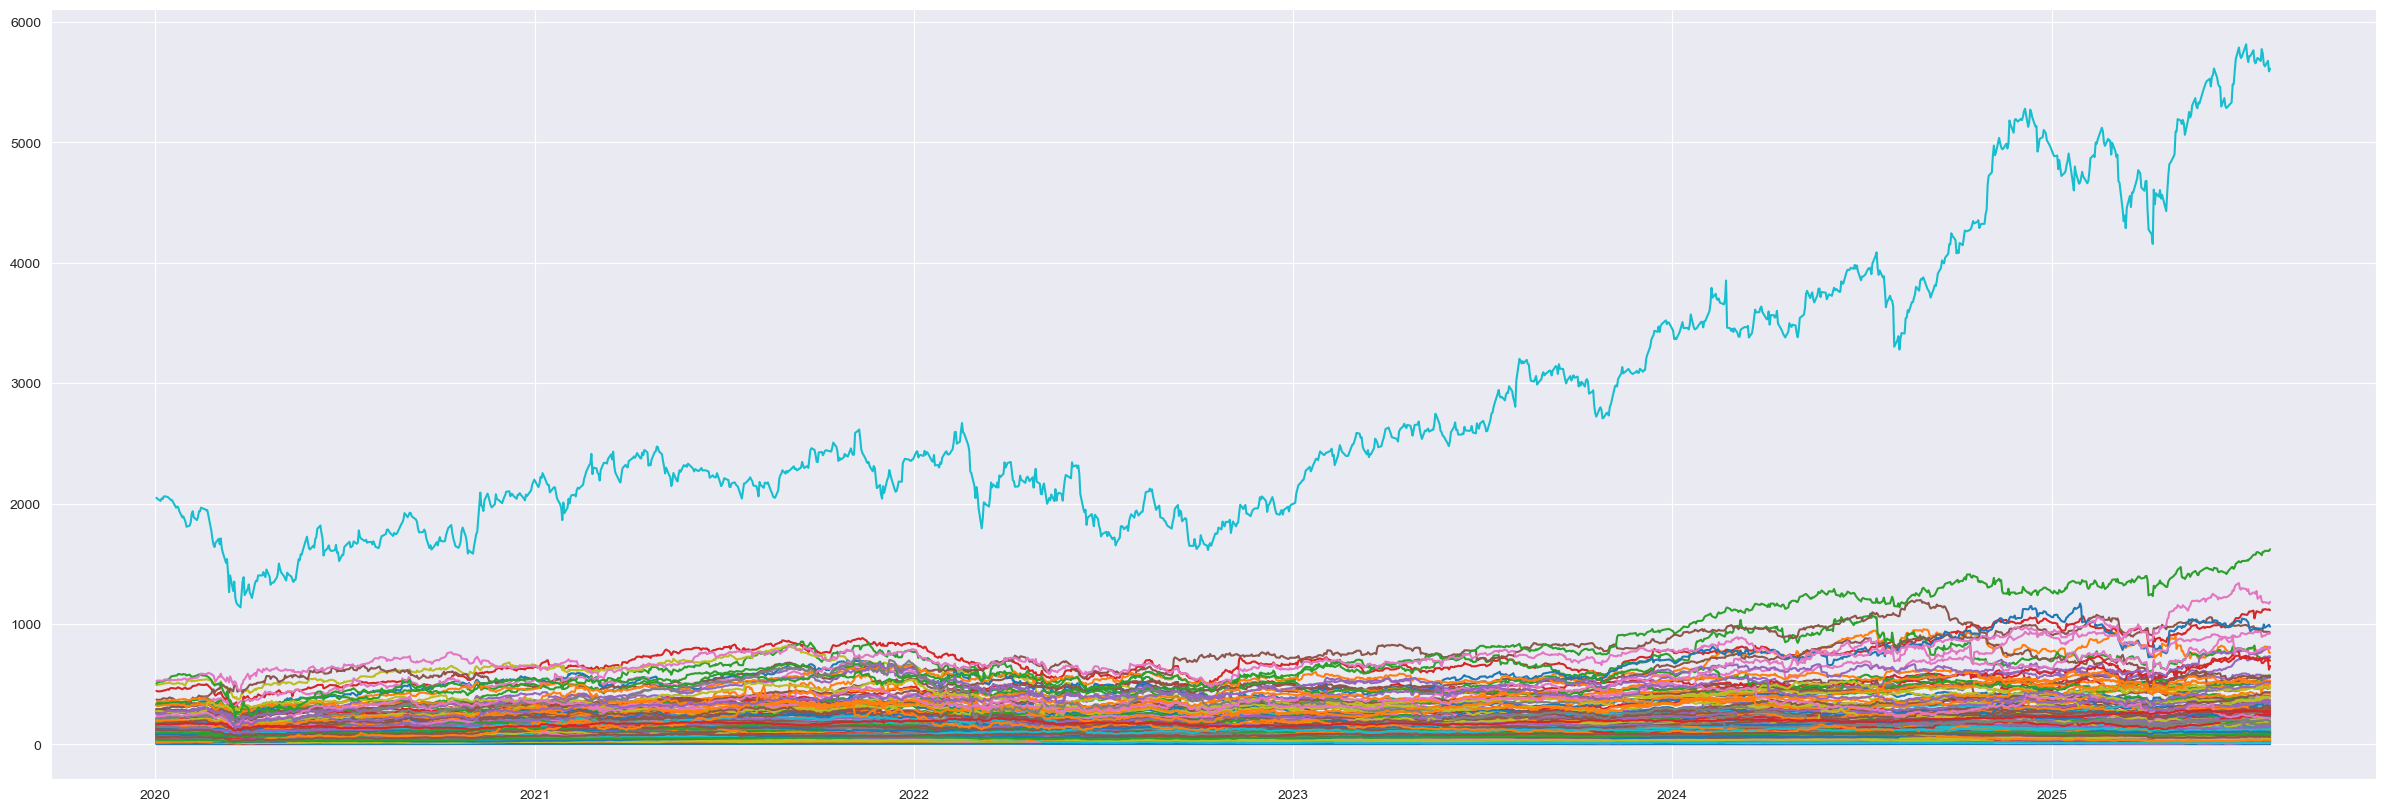

In [34]:
vis.plot_tickers_values(all_dict)

This function plots the returns calculated from close prices of each ticker on a matplotlib graph <br>
_function is found in visualisations.py_

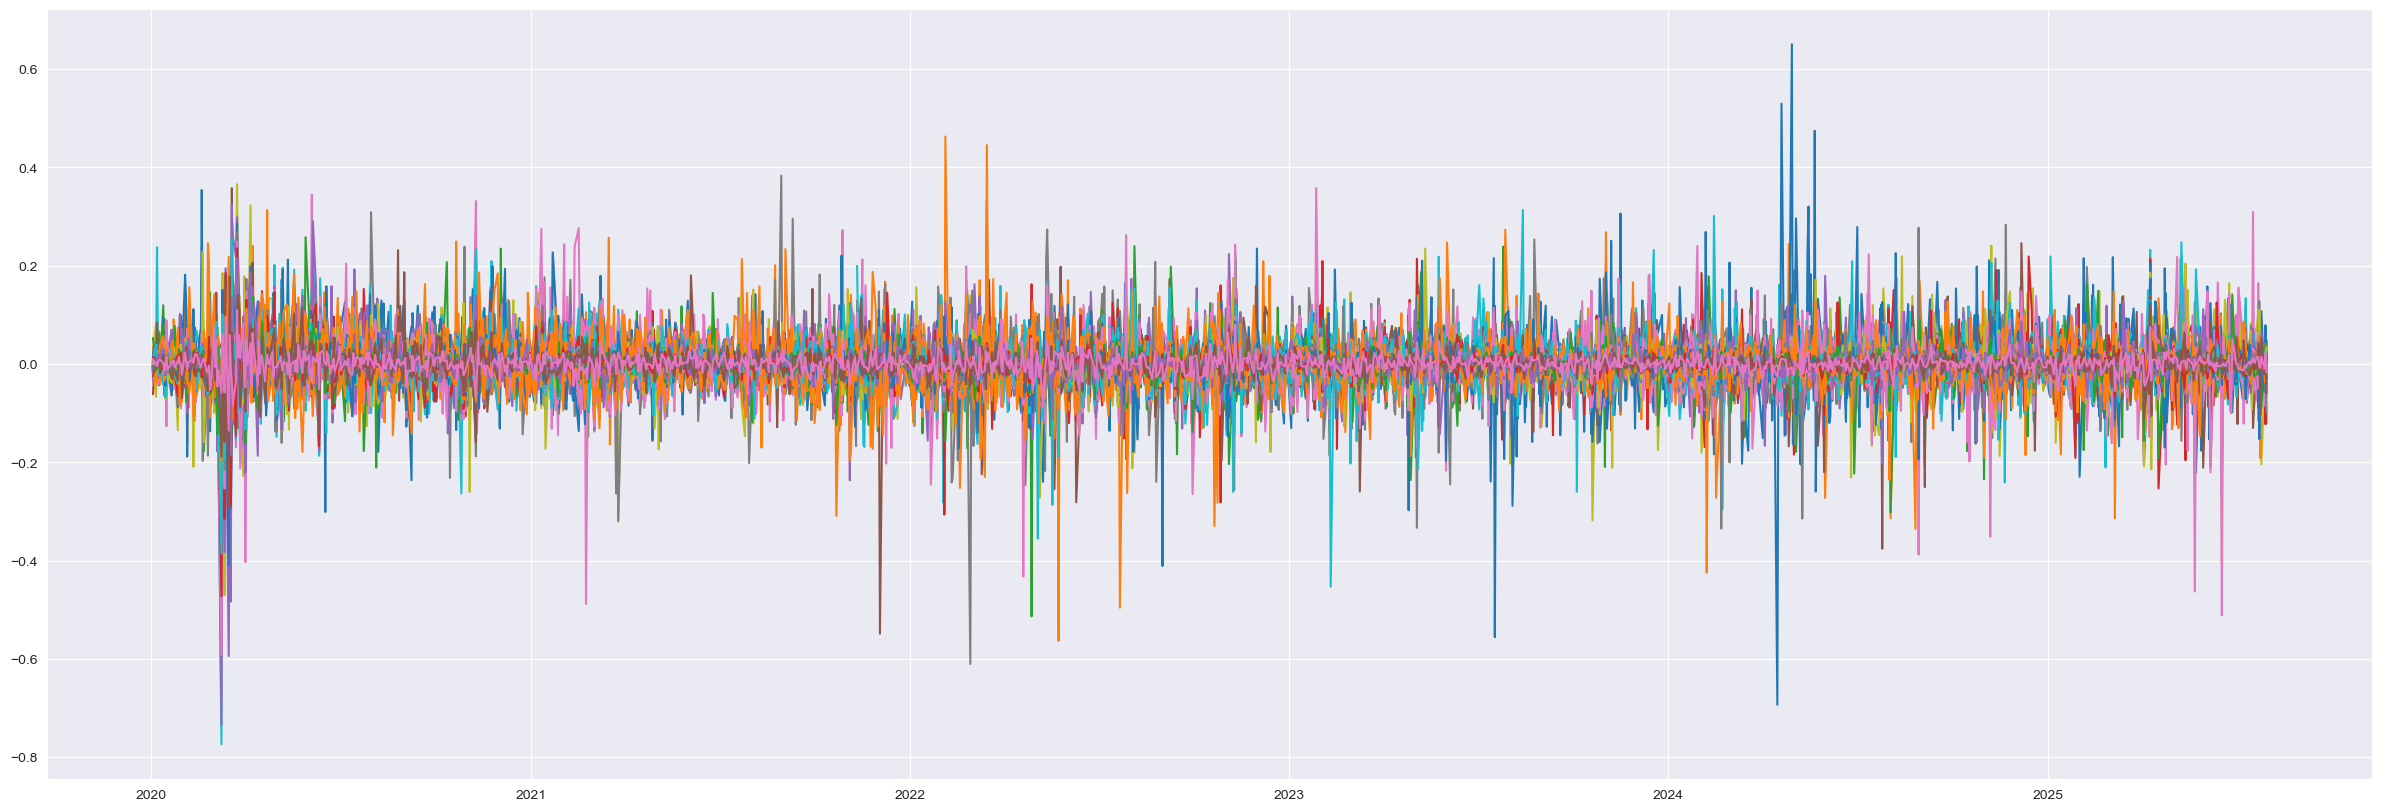

In [35]:
df_returns=vis.plot_tickers_return(all_dict)

## Exploring Correlation Methods

### Pearson Correlation
Linear correlation that measures the strength and direction of a linear relationship between two variables.<br>
**Use in stocks:** Not ideal on its own; it gives equal weight to all data points, so it doesn’t capture recent dynamics or handle outliers well.

---
### Spearman Correlation
Rank-based correlation that assesses how well the relationship between two variables can be described using a monotonic function.<br>
**Use in stocks:** More robust to outliers and useful for capturing consistent directional relationships, even if not linear.

---
### EWMA Correlation
Exponentially Weighted Moving Average correlation that gives more weight to recent data points.<br>
**Use in stocks:** Very useful for tracking changing relationships over time, especially in volatile markets.

---
### Rolling Window Correlation
Computes correlation over a sliding window of time, capturing localized relationships.<br>
**Use in stocks:** Good for observing short-term changes in correlation, particularly useful in backtesting strategies.

---
### Additional Methods Explored

**Kendall Tau Correlation** – Rank-based correlation like Spearman but with a different calculation; slower and more niche, useful for small datasets.<br>
**Partial Correlation** – Measures the relationship between two variables while controlling for others; useful when filtering out confounding effects.<br>
**Distance Correlation** – Captures both linear and nonlinear relationships; detects hidden dependencies but not limited to -1 to 1 range.<br>
**Mutual Information** – Measures how much information one variable gives about another; useful in machine learning and nonlinear analysis.<br>
**Copula-Based Correlation** – Captures dependency structures in the tails of distributions; valuable for modeling extreme events and risk.

-------------------------------------------------------------------------------------------
### Choice: EWMA Correlation
The choice of correlation method is the Exponentially Weighted Moving Average, this has been chosen as we are working with time series data where more recent values have a larger affect then older values on the market. EWMA Correlation is less computationally expensive as it follows linear time complexity, O(n) due to a single pass through the data, and requires less memory than Rolling Window Correlation as it only requires storing the most recent correlation value.

In [36]:
# --- Calculate Exponentially Weighted Moving Average (EWMA) Correlation Matrix ---
# This gives more weight to recent values.
# The `span` parameter determines the decay rate.
# .corr() on the EWM object computes the EWMA correlation matrix.
# We then take the last complete correlation matrix from the multi-indexed result.
ewma_corr_df = df_returns.ewm(span=ewma_span).corr()

# Get the most recent EWMA correlation matrix
# df_returns.index[-1] gets the last date in your returns DataFrame.
correlation_matrix = ewma_corr_df.xs(df_returns.index[-1], level=0)

## Visualing correlation using a heatmap
This function plots a heatmap comparing the correlation of all the given stock tickers

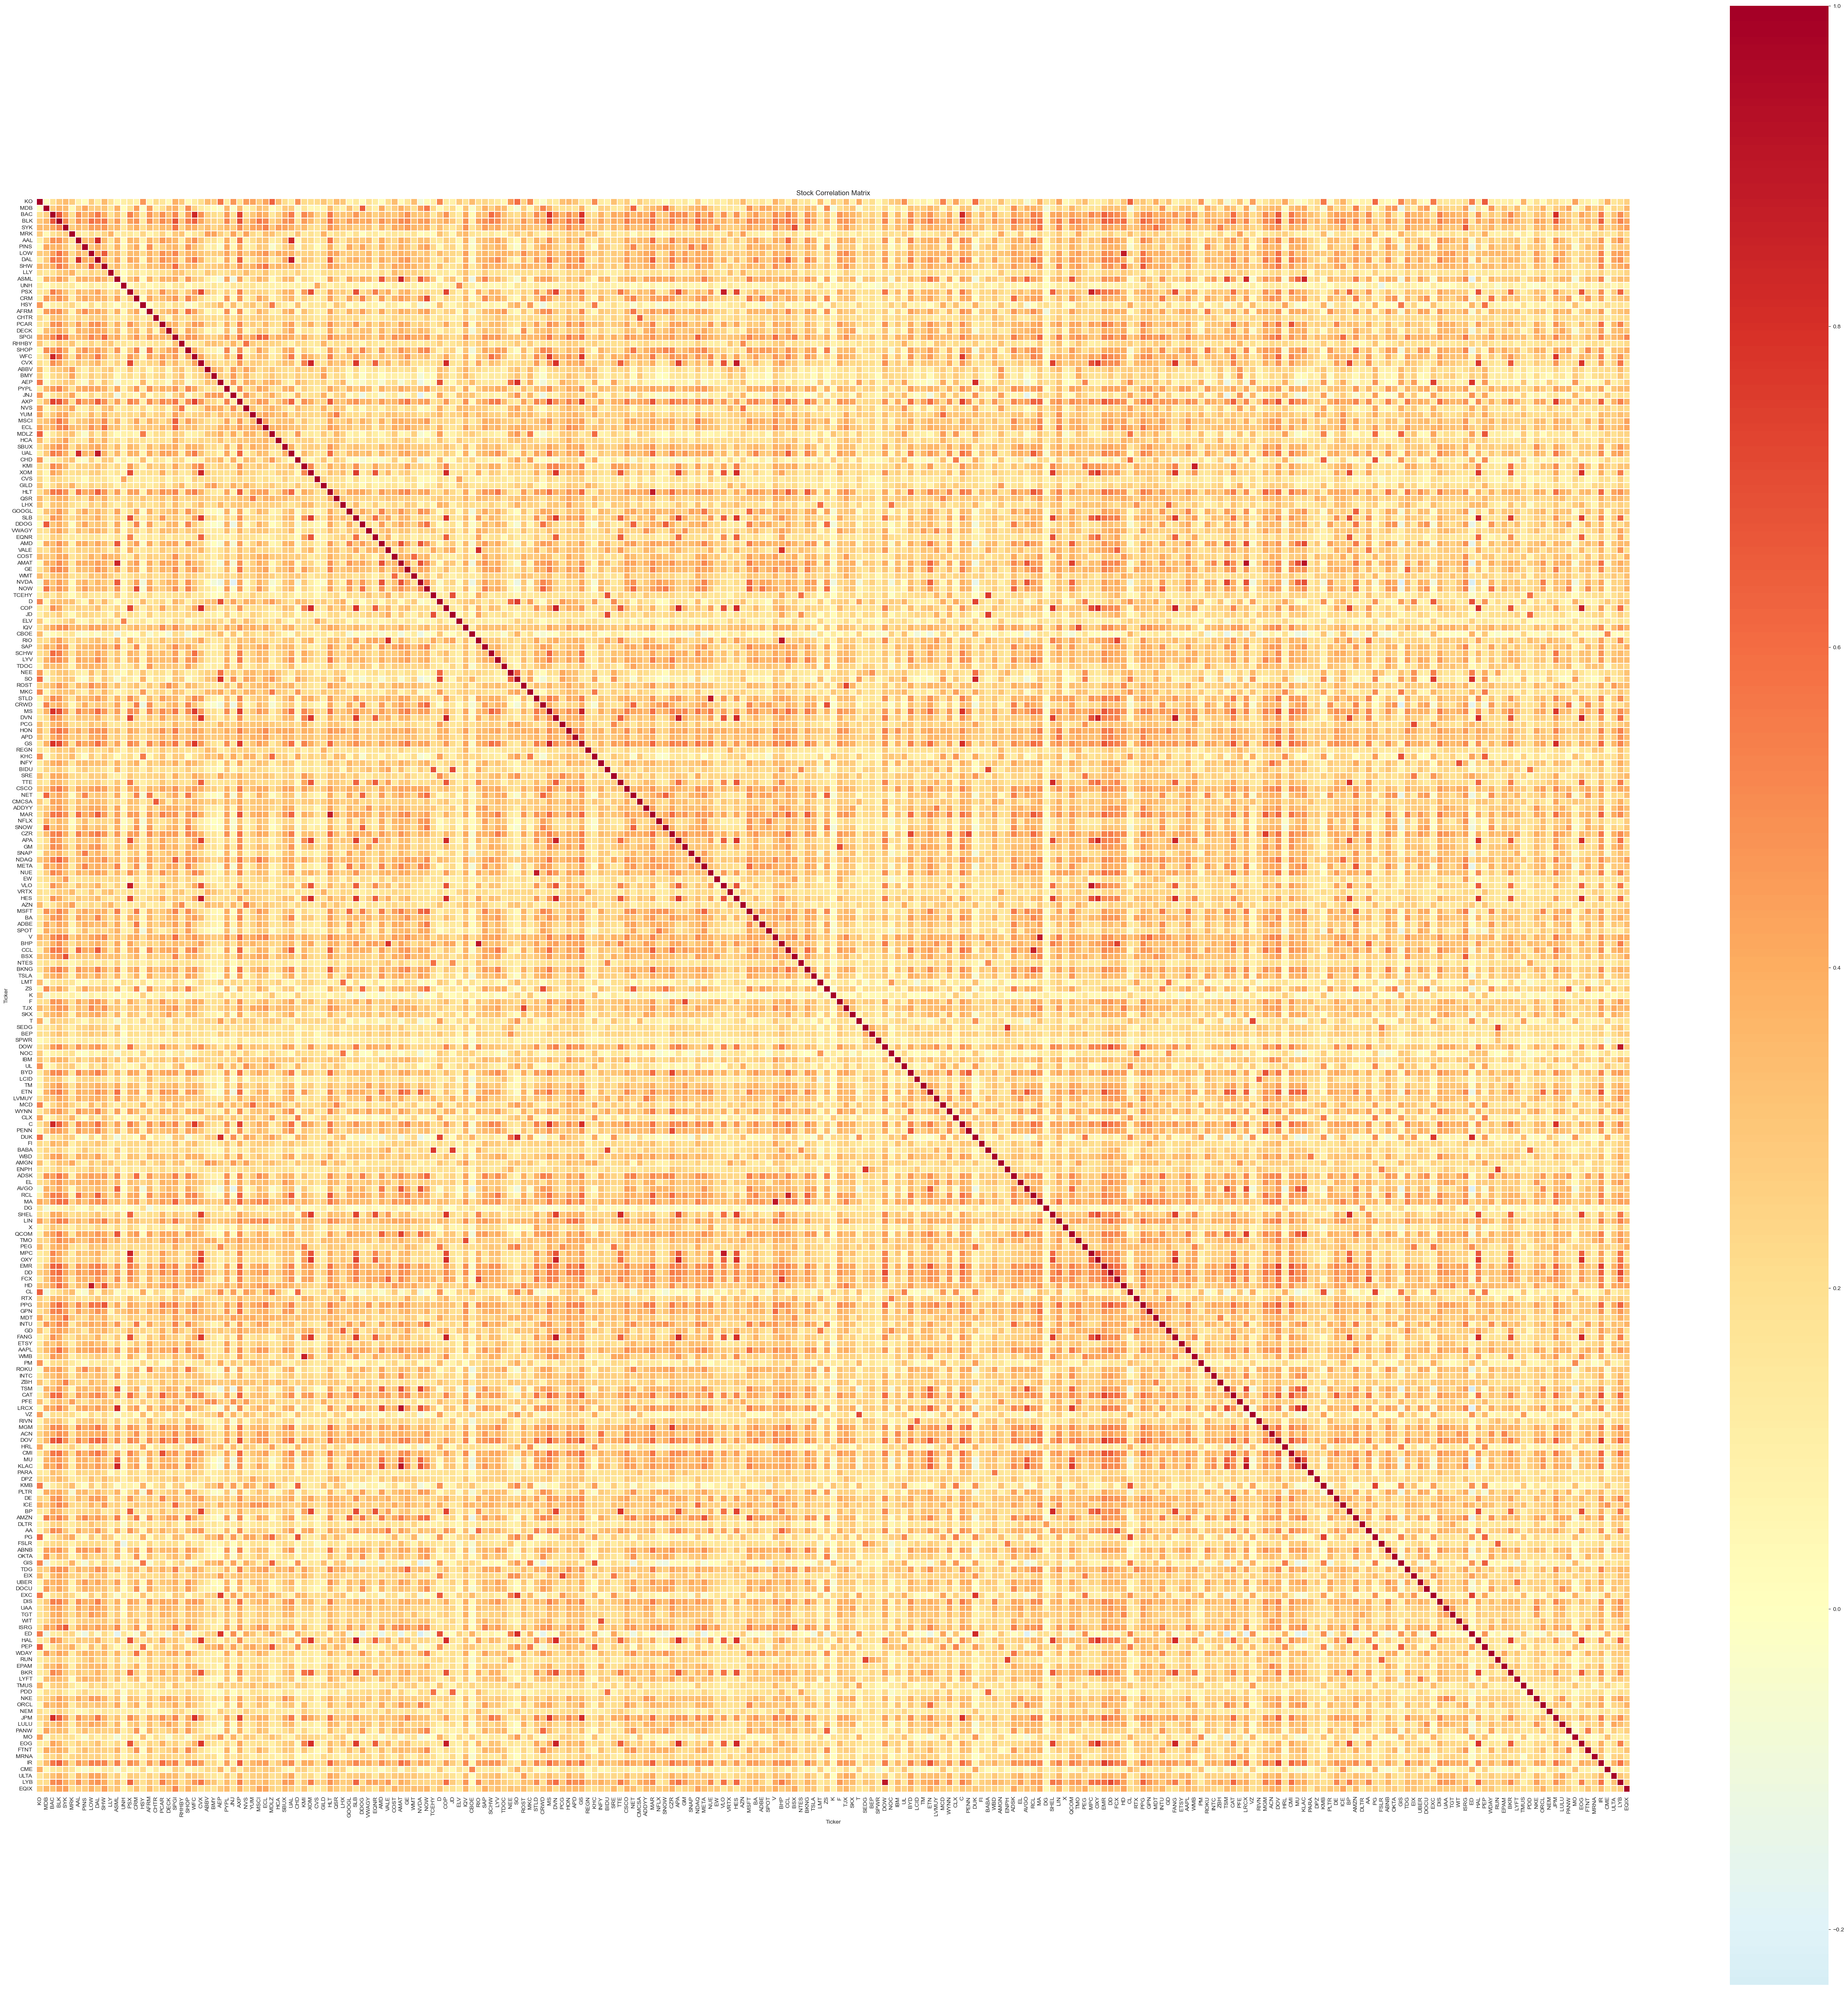

In [37]:
vis.heatmap_correlations(correlation_matrix)

In [38]:
final_groups=grouping.grouping(grouping_minimum_correlation,correlation_matrix,2)

print(final_groups)
for group in final_groups:
    temp=""
    for ticker in group:
        temp=f"{temp}\n{ticker} = {yf.Ticker(ticker).info['longName']}"
    print(temp," \n")

[['PSX', 'VLO', 'MPC'], ['AMAT', 'LRCX', 'KLAC'], ['COP', 'DVN', 'APA', 'FANG', 'EOG']]

PSX = Phillips 66
VLO = Valero Energy Corporation
MPC = Marathon Petroleum Corporation  


AMAT = Applied Materials, Inc.
LRCX = Lam Research Corporation
KLAC = KLA Corporation  


COP = ConocoPhillips
DVN = Devon Energy Corporation
APA = APA Corporation
FANG = Diamondback Energy, Inc.
EOG = EOG Resources, Inc.  



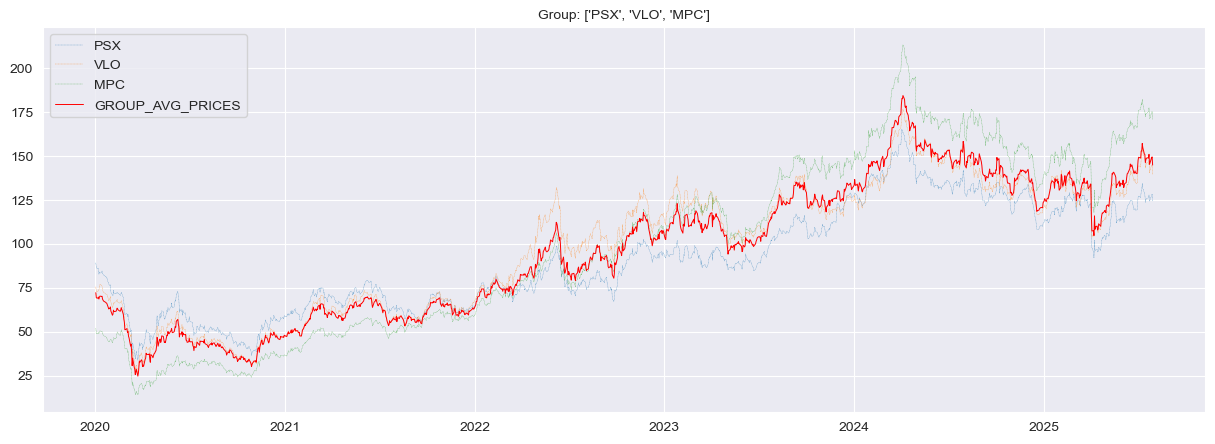

MPC vs GROUP_EWM_AVG (excluding MPC): 0.993,  Marathon Petroleum Corporation
VLO vs GROUP_EWM_AVG (excluding VLO): 0.992,  Valero Energy Corporation
PSX vs GROUP_EWM_AVG (excluding PSX): 0.981,  Phillips 66

intergroup correlation:0.87097


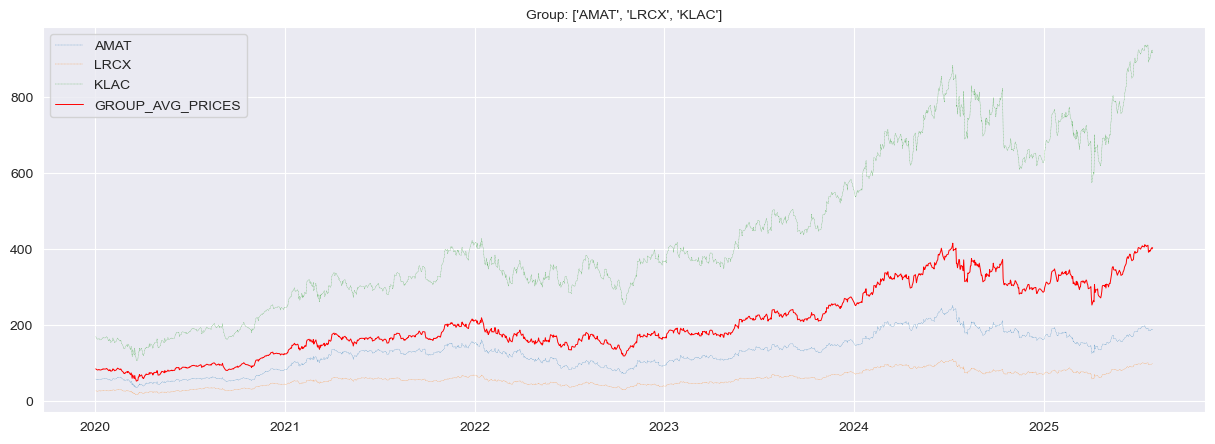

KLAC vs GROUP_EWM_AVG (excluding KLAC): 0.974,  KLA Corporation
LRCX vs GROUP_EWM_AVG (excluding LRCX): 0.982,  Lam Research Corporation
AMAT vs GROUP_EWM_AVG (excluding AMAT): 0.978,  Applied Materials, Inc.

intergroup correlation:0.91880


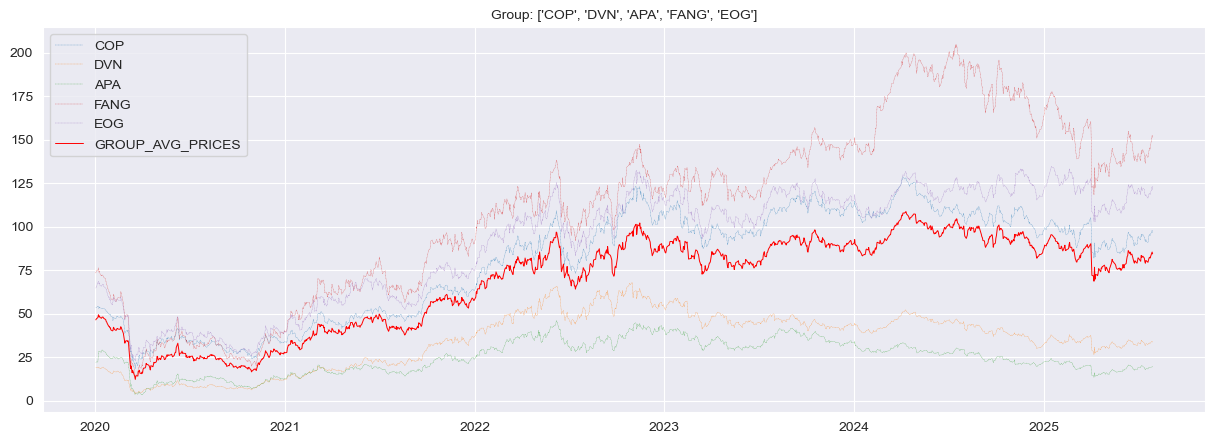

EOG vs GROUP_EWM_AVG (excluding EOG): 0.999,  EOG Resources, Inc.
FANG vs GROUP_EWM_AVG (excluding FANG): 0.977,  Diamondback Energy, Inc.
APA vs GROUP_EWM_AVG (excluding APA): 0.923,  APA Corporation
DVN vs GROUP_EWM_AVG (excluding DVN): 0.954,  Devon Energy Corporation
COP vs GROUP_EWM_AVG (excluding COP): 0.997,  ConocoPhillips

intergroup correlation:0.84566


In [39]:
for group in final_groups:
    plt.figure(figsize=(15, 5))  # Create a new figure for each group

    # Step 1: Get closing prices for all stocks in this group
    group_closes = pd.DataFrame()
    for stock in group:
        group_closes[stock] = all_dict[stock]['Close']
        plt.plot(group_closes[stock], label=stock, linestyle='dashed', linewidth=0.2)

    # Step 2: Calculate daily average across all stock prices
    group_avg_prices = group_closes.mean(axis=1)

    # Step 3: Plot the average prices
    plt.plot(group_avg_prices, label='GROUP_AVG_PRICES', linewidth=0.7, color='red')

    # Step 4: Make it look nice
    plt.title(f'Group: {group}',size=10)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # Calculate correlation using EWM smoothed prices
    print_stats = ""
    for stock in group:
        # Apply EWM to individual stock prices first
        stock_ewm = group_closes[stock].ewm(span=ewma_span).mean()

        # Create group EWM average excluding the current stock
        other_stocks = [s for s in group if s != stock]
        other_prices_ewm = group_closes[other_stocks].ewm(span=ewma_span).mean()
        group_avg_excluding_stock = other_prices_ewm.mean(axis=1)

        # Correlate EWM-smoothed stock prices with EWM-smoothed group average
        corr_with_avg = stock_ewm.corr(group_avg_excluding_stock)
        print_stats = (f"{stock} vs GROUP_EWM_AVG (excluding {stock}): {corr_with_avg:.3f},  "
                       f"{yf.Ticker(stock).info['longName']}\n{print_stats}")

    print(print_stats)

    group_corr_matrix = correlation_matrix.loc[group, group]
    # Get upper triangle (avoid counting each pair twice)
    avg_corr = group_corr_matrix.where(np.triu(np.ones_like(group_corr_matrix, dtype=bool), k=1)).stack().mean()
    print(f"intergroup correlation:{avg_corr:.5f}")